In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
import torchmetrics
import lightning as L
import albumentations as A

from albumentations.pytorch import ToTensorV2
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.models import EfficientNet_B4_Weights
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger
from torchvision.datasets import ImageFolder 

In [2]:
class HistogramEqualizationAndBlur(object):
    def __init__(self, blur_kernel_size=(5, 5)):
        self.blur_kernel_size = blur_kernel_size

    def __call__(self, img):
        # Convert PIL image to OpenCV format (NumPy array)
        img = np.array(img)

        # Convert RGB to HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        # Apply histogram equalization on the V (Value) channel
        hsv_img[:, :, 2] = cv2.equalizeHist(hsv_img[:, :, 2])

        # Convert back to RGB
        img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

        # Apply Gaussian Blur
        img = cv2.GaussianBlur(img, self.blur_kernel_size, 0)

        # Convert back to PIL image
        img = Image.fromarray(img)
        
        return img


In [3]:
import os
import shutil
import random

# Definir las rutas
base_dir = 'LSM_Hand_Crops/imagev2'
train_dir = 'LSM_Hand_Crops/train_v2'
test_dir = 'LSM_Hand_Crops/test_v2'

# Crear directorios de entrenamiento y prueba
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Obtener las etiquetas (nombres de las carpetas)
labels = os.listdir(base_dir)

# Crear subdirectorios para cada etiqueta en entrenamiento y prueba
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Definir la proporción de datos de prueba
test_ratio = 0.2

# Mover las imágenes a los directorios correspondientes
for label in labels:
    image_files = os.listdir(os.path.join(base_dir, label))
    random.shuffle(image_files)
    
    test_count = int(len(image_files) * test_ratio)
    test_images = image_files[:test_count]
    train_images = image_files[test_count:]
    
    for image in test_images:
        src = os.path.join(base_dir, label, image)
        dst = os.path.join(test_dir, label, image)
        shutil.move(src, dst)
    
    for image in train_images:
        src = os.path.join(base_dir, label, image)
        dst = os.path.join(train_dir, label, image)
        shutil.move(src, dst)

print("Imágenes separadas en conjuntos de entrenamiento y prueba.")

Imágenes separadas en conjuntos de entrenamiento y prueba.


In [4]:

# Definir las transformaciones con data augmentation para el conjunto de entrenamiento
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar las imágenes a 224x224 píxeles
    transforms.RandomHorizontalFlip(),  # Aumento de datos: flip horizontal aleatorio
    transforms.RandomRotation(10),  # Aumento de datos: rotación aleatoria
    HistogramEqualizationAndBlur(blur_kernel_size=(5, 5)),  # Aplicar histograma y desenfoque gaussiano
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización
])

# Definir las transformaciones para el conjunto de prueba
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar las imágenes a 224x224 píxeles
    HistogramEqualizationAndBlur(blur_kernel_size=(5, 5)),  # Aplicar histograma y desenfoque gaussiano
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización
])

In [5]:
# Crear los datasets utilizando ImageFolder
train_dataset = ImageFolder(root='LSM_Hand_Crops/train_v2', transform=train_transform)
test_dataset = ImageFolder(root='LSM_Hand_Crops/test_v2', transform=test_transform)

train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 523
Number of validation samples: 131
Number of testing samples: 154


In [6]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

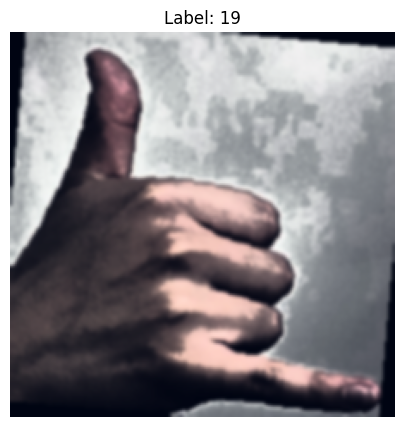

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# Assuming `train_loader` is defined and provides batches of images and labels.
images, labels = next(iter(train_loader))

# Select the first image and its label
image = images[1]
label = labels[1]

# Display the image
plt.figure(figsize=(5, 5))
plt.axis("off")
plt.title(f"Label: {label.item()}")  # Convert label to a scalar if it's a tensor
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:1], padding=2,normalize=True), (1, 2, 0)))
plt.show()


tensor([ 2,  9, 19, 16, 18])
tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0]])


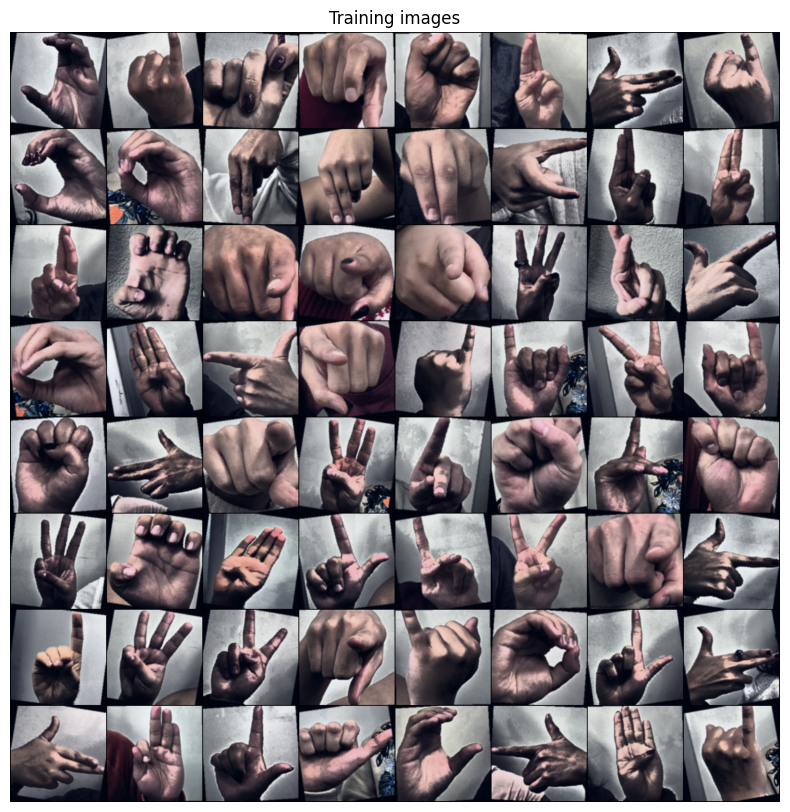

In [12]:
images, labels = next(iter(train_loader))

one_hot = torch.nn.functional.one_hot(labels)

print(labels[:5])
print(one_hot[:5])

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], padding=2,normalize=True), (1, 2, 0)))
plt.show()

In [13]:
class LSMCnnModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        """Initialize the LMSCnnModel class.

            Args:
                model (torch.nn.Module): The CNN model to be used for training and inference.
                learning_rate (float): The learning rate for the optimizer.
        """
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=26)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=26)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=26)

    def forward(self, x):
        """Forward pass of the model.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, 3, 120, 120)

            Returns:
                torch.Tensor: Output tensor after passing through the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        # true_labels = true_labels - 1
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        """Perform a training step.

            Args:
                batch: A batch of training data containing features and labels.
                batch_idx (int): Index of the current batch in the epoch.

            Returns:
                torch.Tensor: Loss tensor to be optimized
        """
        loss, true_labels, predicted_labels = self._shared_step(batch)
        
        self.log("train_loss", loss, on_epoch=True, on_step=False)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        """Perform a validation step.

            Args:
                batch: A batch of validation data containing features and labels.
                batch_idx (int): Index of the current batch in the validation set.

            Returns:
                torch.Tensor: Validation loss tensor
        """
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        with torch.no_grad():
            loss, true_labels, predicted_labels = self._shared_step(batch)
            self.test_acc(predicted_labels, true_labels)
            self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        """Configure the optimizer for training.

            Returns:
                torch.optim.Optimizer: Optimizer for training
        """
        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        return optimizer

In [14]:
class LSMDataModule(L.LightningDataModule):
    def __init__(self, data_path="LSM_Hand_Crops", batch_size=64, num_workers=0, train_transform=None, test_transform=None):
        super().__init__()
        self.batch_size = batch_size
        self.data_path = data_path
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.setup()
        
    def setup(self, stage=None):
        
        train = ImageFolder(
            root=f"{self.data_path}/train_v2", 
            transform=self.train_transform
        )
        
        self.test = ImageFolder(
            root=f"{self.data_path}/test_v2", 
            transform=self.test_transform
        )

        train_size = int(len(train) * 0.8)
        val_size = len(train) - train_size
        
        self.train, self.valid = random_split(train, lengths=[train_size, val_size])
        
    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train, 
            batch_size=self.batch_size,
            shuffle=True, 
            num_workers=self.num_workers
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid, 
            batch_size=self.batch_size,
            shuffle=False, 
            num_workers=self.num_workers
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(   
            dataset=self.test, 
            batch_size=self.batch_size,
            shuffle=False, 
            num_workers=self.num_workers
        )
        return test_loader

In [15]:
pytorch_model = torch.hub.load('pytorch/vision:v0.13.0', 'efficientnet_b4', weights='IMAGENET1K_V1')

Using cache found in C:\Users\david/.cache\torch\hub\pytorch_vision_v0.13.0


In [16]:
pytorch_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [17]:
for param in pytorch_model.parameters():
    param.requires_grad = False
    
for param in pytorch_model.features[-2:].parameters():
    param.requires_grad = True
    
    
# Ensure the model's final layer is set to output 26 classes
pytorch_model.classifier[1] = torch.nn.Linear(1792, 26)

In [18]:
pytorch_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [19]:
weights = EfficientNet_B4_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()
preprocess_transform

ImageClassification(
    crop_size=[380]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [20]:
albumentations_augmentations = A.Compose([
    A.ChannelShuffle(p=0.5),  # Mezclar canales
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),  # Ajustar el gamma aleatoriamente
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Brillo y contraste aleatorios
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),  # Ecualización adaptativa
    A.MedianBlur(blur_limit=5, p=0.5),  # Desenfoque mediano
    A.ImageCompression(quality_lower=30, quality_upper=70, p=0.5),  # Compresión JPEG
])
 
# Pipeline combinado
class CombinedTransform:
    def __init__(self, augmentations, preprocess):
        self.augmentations = augmentations
        self.preprocess = preprocess

    def __call__(self, image):
        # Convertir PIL a numpy para Albumentations
        image = np.array(image)
        augmented = self.augmentations(image=image)
        augmented_image = augmented["image"]
        # Convertir numpy de regreso a PIL para torchvision
        augmented_image = Image.fromarray(augmented_image)
        # Aplicar las transformaciones de preprocesamiento
        return self.preprocess(augmented_image)

# Crear pipelines de entrenamiento y prueba
train_transform = CombinedTransform(albumentations_augmentations, preprocess_transform)
test_transform = preprocess_transform  # Sólo preprocesamiento para pruebas


In [27]:
import torch
import pickle

# Cargar tu modelo desde el checkpoint
checkpoint_path = "logs/lsm-cnn-model/version_8/checkpoints/epoch=11-step=204.ckpt"
lsm_cnn_model = LSMCnnModel.load_from_checkpoint(checkpoint_path, model=pytorch_model, learning_rate=0.01)

# Guardar el modelo como Pickle
pickle_path = "lsm_cnn_model.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(lsm_cnn_model, f)

print(f"Modelo guardado en {pickle_path}")


Modelo guardado en lsm_cnn_model.pkl


In [22]:
dm = LSMDataModule(batch_size=32, num_workers=4,
                       train_transform=preprocess_transform,
                       test_transform=preprocess_transform)

In [24]:
trainer = L.Trainer(
    max_epochs=50,
    accelerator="gpu",
    logger=CSVLogger(save_dir="logs/", name="lsm-cnn-modelv1"),
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
lsm_cnn_model = LSMCnnModel(model=pytorch_model, learning_rate=0.01)

dm = LSMDataModule(batch_size=32, num_workers=4,
                       train_transform=preprocess_transform,
                       test_transform=preprocess_transform)

In [19]:
trainer = L.Trainer(
    max_epochs=50,
    accelerator="gpu",
    logger=CSVLogger(save_dir="logs/", name="lsm-cnn-modelv1"),
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)],
)


trainer.fit(model=lsm_cnn_model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | EfficientNet       | 17.6 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
5.3 M     Trainable params
12.3 M    Non-trainable params
17.6 M    Total params
70.381   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

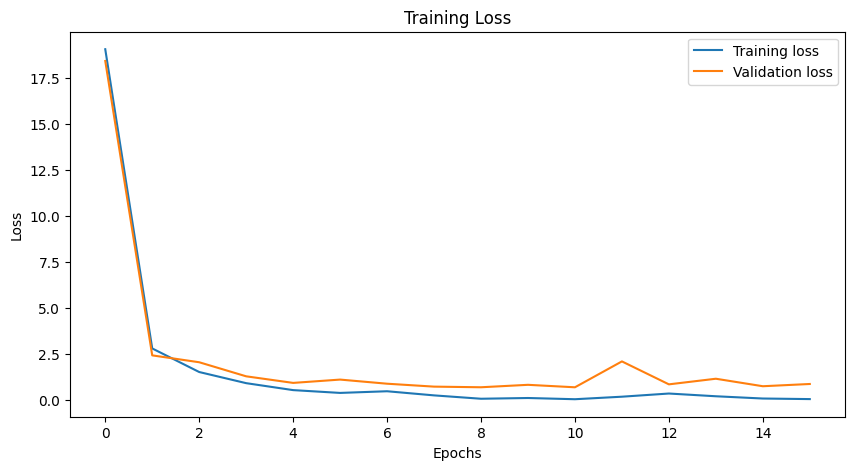

In [20]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
# Plot the training loss over epochs
ax.plot(df_epochs['train_loss'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_loss'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

In [25]:
trainer.test(model=lsm_cnn_model, datamodule=dm)

You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8896104097366333     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8896104097366333}]

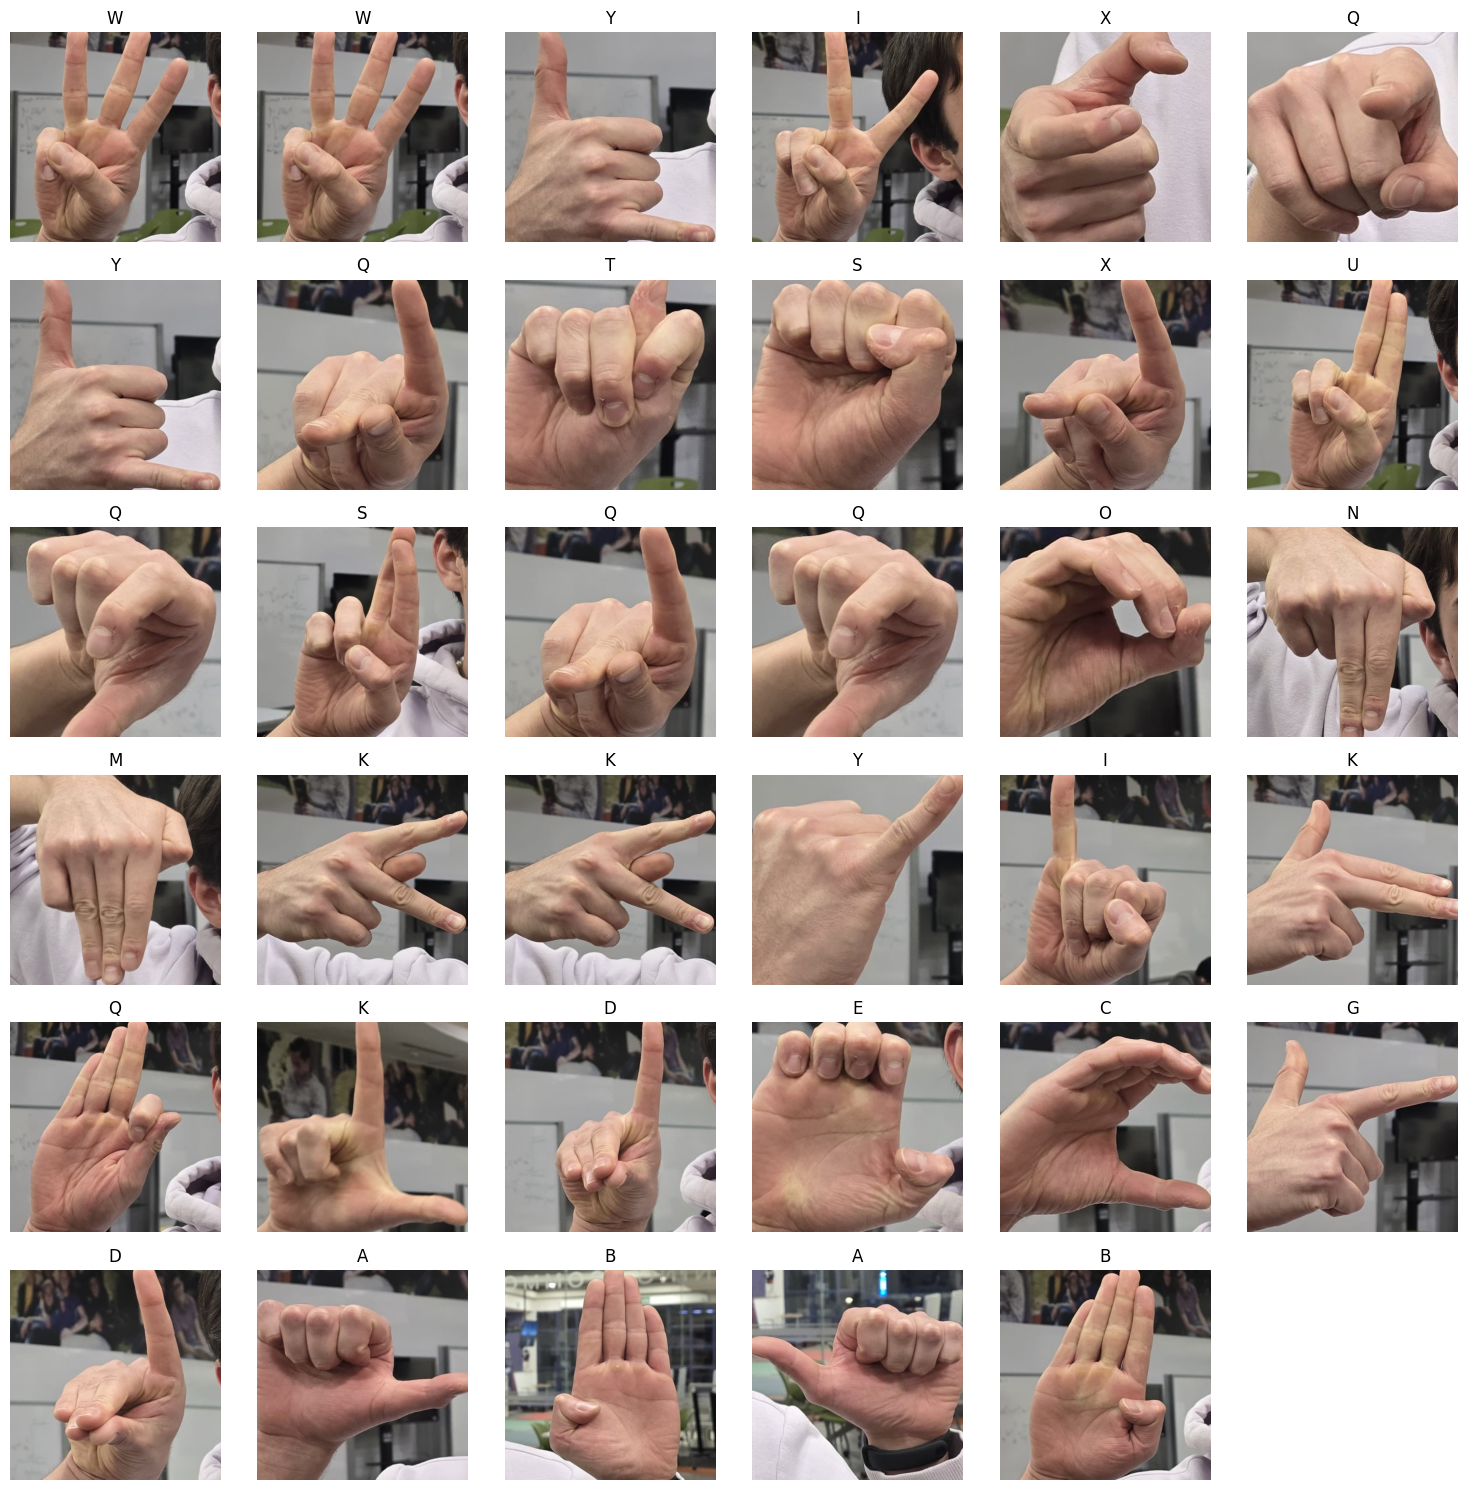

In [26]:
import os
import cv2
import mediapipe as mp
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.models import EfficientNet_B4_Weights
from torchvision import transforms

# Initialize MediaPipe
mp_hands = mp.solutions.hands

# Function to get the bounding box with margins
def get_hand_bbox(landmarks, image_width, image_height, margin=20):
    x_coords = [lm.x for lm in landmarks.landmark]
    y_coords = [lm.y for lm in landmarks.landmark]
    
    x_min = int(min(x_coords) * image_width)
    x_max = int(max(x_coords) * image_width)
    y_min = int(min(y_coords) * image_height)
    y_max = int(max(y_coords) * image_height)
    
    # Add margins
    x_min = max(x_min - margin, 0)
    x_max = min(x_max + margin, image_width)
    y_min = max(y_min - margin, 0)
    y_max = min(y_max + margin, image_height)
    
    # Make bounding box square
    bbox_size = max(x_max - x_min, y_max - y_min)
    x_center = (x_min + x_max) // 2
    y_center = (y_min + y_max) // 2
    x_min = max(x_center - bbox_size // 2, 0)
    x_max = min(x_center + bbox_size // 2, image_width)
    y_min = max(y_center - bbox_size // 2, 0)
    y_max = min(y_center + bbox_size // 2, image_height)
    
    return x_min, x_max, y_min, y_max

# Path to the folder with test images
image_folder_path = "new_image_test"

# Pre-trained weights and transformations
weights = EfficientNet_B4_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()

lsm_cnn_model.eval()

# Load the dataset to map labels
train_dataset = ImageFolder(root='LSM_Hand_Crops/train_v2')  # Update path if needed

# Store processed images and predictions
cropped_images = []
predicted_classes = []

# MediaPipe Hand Detection and Cropping
with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
    for filename in os.listdir(image_folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder_path, filename)
            
            # Load and process the image
            image = cv2.imread(image_path)
            image_height, image_width, _ = image.shape
            results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            
            if results.multi_hand_landmarks:
                # Process the first detected hand
                hand_landmarks = results.multi_hand_landmarks[0]
                x_min, x_max, y_min, y_max = get_hand_bbox(hand_landmarks, image_width, image_height)
                cropped_image = image[y_min:y_max, x_min:x_max]
                cropped_image_pil = Image.fromarray(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
                
                # Preprocess the cropped hand for the model
                preprocessed_image = preprocess_transform(cropped_image_pil).unsqueeze(0)
                
                # Prediction
                with torch.no_grad():
                    prediction = lsm_cnn_model(preprocessed_image)
                    predicted_class = torch.argmax(prediction).item()
                
                # Store cropped image and class name
                cropped_images.append(cropped_image_pil)
                predicted_classes.append(train_dataset.classes[predicted_class])
            else:
                print(f"No hands detected in the image: {filename}")

# Display the results in a grid
num_images = len(cropped_images)
grid_size = int(np.ceil(np.sqrt(num_images)))
fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

for i in range(grid_size * grid_size):
    if i < num_images:
        ax = axs[i // grid_size, i % grid_size]
        ax.imshow(cropped_images[i])
        ax.set_title(predicted_classes[i])
        ax.axis("off")
    else:
        axs[i // grid_size, i % grid_size].axis("off")

plt.tight_layout()
plt.show()
